# Basic usage of SFRmaker in a scripting context
This example illustrates basic usage of SFRmaker in a scripting context. For examples of using SFRmaker with a configuration file, see the MERAS and Tyler Forks examples.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import flopy
import sfrmaker

### Input requirements
The most basic input requirements of SFRmaker are hydrography and a model grid. Optionally, a model and a DEM can be input, as demonstrated below. See the [documentation](https://aleaf.github.io/sfrmaker/inputs.html) for a more detailed description of inputs.

#### Hydrography
In this example, we will use data that has been downloaded from [NHDPlus](https://nhdplus.com/NHDPlus/NHDPlusV2_data.php). The original file structure in the download has been maintained, allowing us to simply supply SFRmaker with a path to the NHDPlus files:

In [2]:
NHDPlus_paths = '../tylerforks/NHDPlus/'

If we were dealing with more than one drainage basin, the NHDPlus file paths could be included in a list:

In [3]:
NHDPlus_paths_list = ['/NHDPlusGL/NHDPlus04/',
                      '/NHDPlusMS/NHDPlus07/']

### Creating a ``Lines`` instance from NHDPlus
The ``sfrmaker.Lines`` class includes functionality for reading and processing hydrography flowlines. This example shows how to create a ``Lines`` instance from NHDPlus data.

For large hydrography datasets, it is advantageous to filter the data when it is read in. The ``filter`` argument to ``sfrmaker.Lines`` accepts a shapefile path or tuple of bounding box coordinates. In either case, a bounding box tuple is created and passed to the ``filter`` method in the [``fiona`` package](https://fiona.readthedocs.io/en/latest/manual.html), which is fast.

In [4]:
lns = sfrmaker.Lines.from_nhdplus_v2(NHDPlus_paths='../tylerforks/NHDPlus/',
                            bbox_filter='../tylerforks/grid.shp')


loading NHDPlus v2 hydrography data...
for basins:
../tylerforks/NHDPlus/

load finished in 0.08s

Getting routing information from NHDPlus Plusflow table...
finished in 0.03s



Alternatively, ``sfrmaker.Lines`` can be instantiated with separate arguments for each NHDPlus file used:

In [5]:
lines = sfrmaker.Lines.from_nhdplus_v2(NHDFlowlines='../tylerforks/NHDPlus/NHDSnapshot/Hydrography/NHDFlowline.shp',
                                       PlusFlowlineVAA='../tylerforks/NHDPlus/NHDPlusAttributes/PlusFlowlineVAA.dbf',
                                       PlusFlow='../tylerforks/NHDPlus/NHDPlusAttributes/PlusFlow.dbf',
                                       elevslope='../tylerforks/NHDPlus/NHDPlusAttributes/elevslope.dbf',
                                       bbox_filter=(-90.625, 46.3788, -90.4634, 46.4586))


loading NHDPlus v2 hydrography data...

load finished in 0.03s

Getting routing information from NHDPlus Plusflow table...
finished in 0.03s



### Creating a ``Lines`` instance from custom hydrography
Alternatively, a ``Lines`` instance can be created from any hydrography that includes the pertinent attribute fields, which must be specified:

In [6]:
custom_lines = sfrmaker.Lines.from_shapefile(shapefile='../meras/flowlines.shp',
                                             id_column='COMID',  # arguments to sfrmaker.Lines.from_shapefile
                                             routing_column='tocomid',
                                             width1_column='width1',
                                             width2_column='width2',
                                             up_elevation_column='elevupsmo',
                                             dn_elevation_column='elevdnsmo',
                                             name_column='GNIS_NAME',
                                             attr_length_units='feet',  # units of source data
                                             attr_height_units='feet',  # units of source data
                                             )

### Specifying a model grid from a flopy `StructuredGrid` instance
The next step is to specify a model grid. One option is to specify a flopy `StructuredGrid` instance. SFRmaker will then use this internally to create an instance of its own `StructuredGrid` class. In this case, the row and column spacing must be provided in the units of the projected coordinate reference system (CRS) that the model is in, which is typically meters. In this case, our model grid spacing is 250 feet, so we have to convert. 

Specifying a CRS (via the ``crs`` argument) is also important, as it allows SFRmaker to automatically reproject any input data to the same CRS as the model grid. [The best way to do this is with an EPSG code](https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems), as shown below.

See the flopy documentation for more details about `StructuredGrid`.

In [7]:
delr = np.array([250 * 0.3048] * 160)  # cell spacing along a row
delc = np.array([250 * 0.3048] * 111)  # cell spacing along a column

flopy_grid = flopy.discretization.StructuredGrid(delr=delr, delc=delc,
                                                 xoff=682688, yoff=5139052,  # lower left corner of model grid
                                                 angrot=0,  # grid is unrotated
                                                 # projected coordinate system of model (UTM NAD27 zone 15 North)
                                                 crs=26715
                                                 )

### Specifying a model grid from a shapefile
Another option is to create an SFRmaker `StructuredGrid` directly using a shapefile. While the basic underpinings are in place for SFRmaker to support unstructured grids, this option hasn't been fully implemented yet.

Attribute fields with row and column information must be specified. An polygon defining the area where the SFR network will be created can optionally be specified here, or later in the creation of ``SFRData`` (see below).

In [8]:
grid = sfrmaker.StructuredGrid.from_shapefile(shapefile='../tylerforks/grid.shp',
                                              icol='i',  # attribute field with row information
                                              jcol='j',  # attribute field with column information
                                              active_area='../tylerforks/active_area.shp'
                                              )


reading ../tylerforks/grid.shp...


--> building dataframe... (may take a while for large shapefiles)



reading ../tylerforks/active_area.shp...
--> building dataframe... (may take a while for large shapefiles)


With specification of ``active_area``, the grid created above has an **``isfr``** array attribute designating which cells can have SFR:

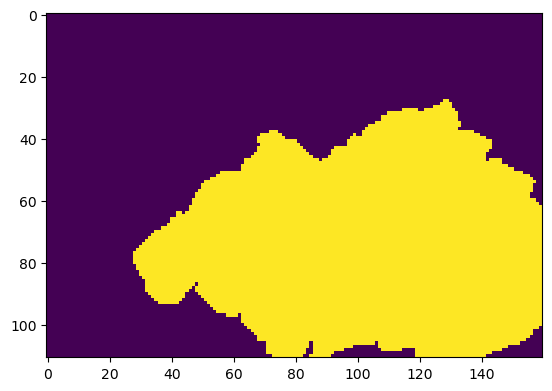

In [9]:
plt.imshow(grid.isfr, interpolation='nearest')

### Using the ``modelgrid`` attached to a flopy model
If no grid is supplied as input, SFRmaker will try to use ``modelgrid`` attribute attached to a supplied flopy model instance. This only works if ``modelgrid`` is valid. Loading a flopy model with a valid model grid requires the grid information to be specified in the namefile header, and that the model be in the same units as the projected CRS. See the flopy documentation for more details

### Specifying a model
While a model is not required to run SFRmaker, specifying a model is advantageous in that it allows SFRmaker to assign valid model layers for reaches. Models are specified as flopy model instances, which can be loaded or created from scratch (see the flopy documentation). In this case, we are loading a model:

In [10]:
m = flopy.modflow.Modflow.load('tf.nam', model_ws='../tylerforks/tylerforks')
m

MODFLOW 5 layer(s) 111 row(s) 160 column(s) 1 stress period(s)

### Creating an SFRData instance
The ``sfrmaker.SFRData`` class is the primary object for creating or modifying an SFR dataset. A ``SFRData`` instance can be created from the ``Lines`` class using the ``to_sfr()`` method.

Either a flopy ``StructuredGrid`` or sfrmaker ``StructuredGrid`` can be supplied. While MODFLOW and flopy support specification of length units, these aren't always specified in the model input files, so it is good practice to specifiy the units explicitly to SFRmaker.

In [11]:
sfrdata = lines.to_sfr(grid=flopy_grid, model=m, model_length_units='feet')


SFRmaker version 0.11.3.post44.dev0+gcd9ad3a

Creating sfr dataset...

Creating grid class instance from flopy Grid instance...


grid class created in 0.35s

Model grid information
structured grid
nnodes: 17,760
nlay: 1
nrow: 111
ncol: 160
model length units: undefined
crs: EPSG:26715
bounds: 682688.00, 5139052.00, 694880.00, 5147510.20
active area defined by: all cells

MODFLOW 5 layer(s) 111 row(s) 160 column(s) 1 stress period(s)

reprojecting hydrography from
EPSG:4269
to
EPSG:26715


Culling hydrography to active area...
starting lines: 45
remaining lines: 42
finished in 0.00s


Intersecting 42 flowlines with 17,760 grid cells...

Building spatial index...


finished in 0.74s

Intersecting 42 features...
42
finished in 0.08s

Setting up reach data... (may take a few minutes for large grids)


finished in 0.27s

Computing widths...

Dropping 48 reaches with length < 12.50 feet...

Repairing routing connections...
enforcing best segment numbering...

Setting up segment data...
Model grid information
structured grid
nnodes: 17,760
nlay: 1
nrow: 111
ncol: 160
model length units: undefined
crs: EPSG:26715
bounds: 682688.00, 5139052.00, 694880.00, 5147510.20
active area defined by: all cells


Time to create sfr dataset: 1.65s



### The ``SFRData`` class
Internally, the SFRData class mostly uses the data model for the MODFLOW-2005 style SFR2 package (which includes MODFLOW-NWT), which organizes the input into segments and reaches. Segment and reach data are stored in the ``reach_data`` and ``segment_data`` attribute DataFrames. In addition to the MODFLOW-2005 data, reach numbers and their routing connections (as needed for MODFLOW-6) are also stored. On writing of SFR package input, MODFLOW-6 style input can be created via the ``sfrmaker.mf5to6`` module.

In [12]:
sfrdata.reach_data.loc[sfrdata.reach_data['rno'] == 1, 'strhc1'] = 5

In [13]:
sfrdata.reach_data.head()

,rno,node,k,i,j,iseg,ireach,rchlen,width,slope,...,thts,thti,eps,uhc,outreach,outseg,asum,line_id,name,geometry
511,1,17714,0,110,114,1,1,208.807938,1.000000,0.127779,...,0.0,0.0,0.0,0.0,2,4,31.822330,1815013,None,"LINESTRING (691394.6396657812 5139052, 691410...."
512,2,17715,0,110,115,1,2,294.098938,1.261243,0.060563,...,0.0,0.0,0.0,0.0,3,4,108.465340,1815013,None,"LINESTRING (691451 5139079.028908214, 691471.0..."
513,3,17716,0,110,116,1,3,41.622536,1.531957,0.333944,...,0.0,0.0,0.0,0.0,4,4,159.629288,1815013,None,"LINESTRING (691527.2 5139123.064392628, 691538..."
514,4,17556,0,109,116,1,4,220.366440,1.714090,0.092205,...,0.0,0.0,0.0,0.0,5,4,199.556412,1815013,None,"LINESTRING (691538.8006061709 5139128.2, 69156..."
515,5,17557,0,109,117,1,5,162.617325,1.950304,0.097331,...,0.0,0.0,0.0,0.0,6,4,257.923126,1815013,None,"LINESTRING (691603.4 5139143.66283342, 691624...."


In [14]:
sfrdata.segment_data.head()

,per,nseg,icalc,outseg,iupseg,iprior,nstrpts,flow,runoff,etsw,...,uhc1,hcond2,thickm2,elevdn,width2,depth2,thts2,thti2,eps2,uhc2
0,0,1,1,4,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1297.867432,5.638623,0.0,0.0,0.0,0.0,0.0
1,0,2,1,4,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1297.867432,37.791649,0.0,0.0,0.0,0.0,0.0
2,0,3,1,6,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1278.149658,7.069631,0.0,0.0,0.0,0.0,0.0
3,0,4,1,6,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1278.149658,38.638088,0.0,0.0,0.0,0.0,0.0
4,0,5,1,10,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1211.286133,6.470501,0.0,0.0,0.0,0.0,0.0


### Sampling streambed top elevations from a DEM
While the above dataset contains streambed top elevations read from NHDPlus, a DEM can be sampled to obtain more accurate elevations. If the DEM elevation units are specified, SFRmaker will convert the elevations to model units if needed. See the Streambed_elevation_demo notebook for more information on how this works.

In [15]:
sfrdata.set_streambed_top_elevations_from_dem('../tylerforks/dem_26715.tif', 
                                              elevation_units='meters')

running rasterstats.zonal_stats on buffered LineStrings...


finished in 4.17s


Smoothing elevations...
finished in 0.10s


### Assigning layers to the reaches
Once we have a valid set of streambed elevations, the reaches can be assigned to model layers.

In [16]:
sfrdata.assign_layers()

In [17]:
sfrdata.reach_data.head()

,rno,node,k,i,j,iseg,ireach,rchlen,width,slope,...,thts,thti,eps,uhc,outreach,outseg,asum,line_id,name,geometry
511,1,17714,2,110,114,1,1,208.807938,1.000000,0.040094,...,0.0,0.0,0.0,0.0,2,4,31.822330,1815013,None,"LINESTRING (691394.6396657812 5139052, 691410...."
512,2,17715,2,110,115,1,2,294.098938,1.261243,0.003117,...,0.0,0.0,0.0,0.0,3,4,108.465340,1815013,None,"LINESTRING (691451 5139079.028908214, 691471.0..."
513,3,17716,2,110,116,1,3,41.622536,1.531957,0.207275,...,0.0,0.0,0.0,0.0,4,4,159.629288,1815013,None,"LINESTRING (691527.2 5139123.064392628, 691538..."
514,4,17556,2,109,116,1,4,220.366440,1.714090,0.028292,...,0.0,0.0,0.0,0.0,5,4,199.556412,1815013,None,"LINESTRING (691538.8006061709 5139128.2, 69156..."
515,5,17557,2,109,117,1,5,162.617325,1.950304,0.015271,...,0.0,0.0,0.0,0.0,6,4,257.923126,1815013,None,"LINESTRING (691603.4 5139143.66283342, 691624...."


### Running diagnostics
`SFRData` includes a `run_diagnostics()` method that executes the Flopy checker on the SFR package input. While the Flopy checks are only implemented for MODFLOW-2005 style SFR packages, `run_diagnostics()` works on MODFLOW-6 packages as well, by working of an attached MODFLOW-2005 representation of the MODFLOW-6 SFR input. The following checks are executed:
* **NaNs** (not a number values, which will cause MODFLOW to crash)
* **consecutive segment and reach numbering**
* **segment numbering that only increases** in the downstream direction
* **circular routing sequences** (reaches or segments routing back to themselves)
* **routing connection proximity:** The length of routing connections, as determined by the distance between their cell centers, is compared to 1.25 times the diagonal distance across the cell containing the upstream reach. This benchmark length is equivalent to a diagonal connection between two square cells, where one cell had a spacing of 1.5 times the other cell (the maximum recommended increase in spacing between two adjacent cells; see Anderson and others, 2015). While this routing proximity check can be helpful for identifying egregious routing issues, in practice, it may not be uncommon for valid routing connections to violate this rule. For example, if the ``one_reach_per_cell`` option is used in constructing the SFR package with a large grid size, there may be numerous routing connections that extend across several cells. When non-adjacent routing connections are identified, the user can check the shapefile of routing connections to verify the results.
* **overlapping conductances:** This check identifies instances of collocated reaches, where more than one reach has a connection to the groundwater flow solution in that cell. Collocated reaches may or may not present an issue for a particular model solution, but can potentially promote instability or spurious circulation of flow between the collocated reaches.
* **spurious streambed top elevations:** Values < -10 or > 15,000 are flagged
* **downstream rises in streambed elevation**
* **inconsistencies between streambed elevation and the model grid:** This check looks for streambed bottoms below their respective cell bottoms, which will cause MODFLOW to halt execution, and streambed tops that are above the model top. The latter issue will not prevent MODFLOW from running, but may indicate problems with the input if the differences are large. For coarse grids in areas of high stream density (where there are often multiple streams in a cell), it may be impossible to ensure that all streambed top elevations are at or below the model top. Oftentimes, these reaches are dry anyways (for example, and ephemeral gully that runs off a bluff into a perennial stream, where the cell elevation is based on the elevation of the perennial stream). In any case, it is good practice to check the largest violations by comparing the SFRmaker shapefile output to a DEM and other data in a GIS environment.
* **suprious slopes:** slopes of less than 0.0001 (which can lead to excessive stages with the SFR package's Manning approximation) and greater than 1.0 are flagged.

In [18]:
sfrdata.run_diagnostics(verbose=False)


Running Flopy v. 3.10.0.dev2 diagnostics...
wrote tf_SFR.chk


### Writing an SFR package
Now we can write the package. By default, a MODFLOW-2005 style package is written to the current working directory or the model workspace of the attached model instance.

In [19]:
sfrdata.write_package()

SFRmaker v. 0.11.3.post44.dev0+gcd9ad3a

Running Flopy v. 3.10.0.dev2 diagnostics...
passed.

Checking for continuity in segment and reach numbering...
passed.

Checking for increasing segment numbers in downstream direction...
passed.

Checking for circular routing...
passed.

Checking reach connections for proximity...
5 segments with non-adjacent reaches found.
At segments:
41 20 21 22 23

5 segments with non-adjacent reaches found.
At segments:
41 20 21 22 23


Checking for model cells with multiple non-zero SFR conductances...
24 model cells with multiple non-zero SFR conductances found.
This may lead to circular routing between collocated reaches.
Nodes with overlapping conductances:
k	i	j	iseg	ireach	rchlen	strthick	strhc1
2	110	119	1	8	268.5836486816406	1.0	1.0
2	110	119	2	1	72.61438751220703	1.0	1.0
0	87	122	3	54	35.35249328613281	1.0	1.0
0	87	122	4	33	231.09567260742188	1.0	1.0
0	76	110	5	47	204.88766479492188	1.0	1.0
0	87	122	6	1	30.414600372314453	1.0	1.0
2	84	119	6	7	271.2

passed.

Checking reach_data for inconsistencies between streambed elevations and the model grid...
1 reaches encountered with streambed above model top.
Model top violations:
i j iseg ireach strtop modeltop strhc1 reachID diff
49 15 18 19 922.1929321289062 920.3099975585938 1.0 786 -1.8829345703125


Checking segment_data for inconsistencies between segment end elevations and the model grid...
Segment elevup and elevdn not specified for nstrm=-1439 and isfropt=1
passed.

Checking for streambed slopes of less than 0.0001...
passed.

Checking for streambed slopes of greater than 1.0...
passed.

wrote tf_SFR.chk
wrote /home/runner/work/sfrmaker/sfrmaker/examples/Notebooks/../tylerforks/tylerforks/tf.sfr.


### Writing a MODFLOW-6 SFR package
Alternatively, a MODFLOW-6 style SFR package can be written by specifying ``version='mf6'``

In [20]:
sfrdata.write_package('tf_mf6.sfr', version='mf6')

SFRmaker v. 0.11.3.post44.dev0+gcd9ad3a

Running Flopy v. 3.10.0.dev2 diagnostics...
passed.

Checking for continuity in segment and reach numbering...
passed.

Checking for increasing segment numbers in downstream direction...
passed.

Checking for circular routing...
passed.

Checking reach connections for proximity...


5 segments with non-adjacent reaches found.
At segments:
41 20 21 22 23

5 segments with non-adjacent reaches found.
At segments:
41 20 21 22 23


Checking for model cells with multiple non-zero SFR conductances...
24 model cells with multiple non-zero SFR conductances found.
This may lead to circular routing between collocated reaches.
Nodes with overlapping conductances:
k	i	j	iseg	ireach	rchlen	strthick	strhc1
2	110	119	1	8	268.5836486816406	1.0	1.0
2	110	119	2	1	72.61438751220703	1.0	1.0
0	87	122	3	54	35.35249328613281	1.0	1.0
0	87	122	4	33	231.09567260742188	1.0	1.0
0	76	110	5	47	204.88766479492188	1.0	1.0
0	87	122	6	1	30.414600372314453	1.0	1.0
2	84	119	6	7	271.24835205078125	1.0	1.0
2	84	119	6	9	26.37481117248535	1.0	1.0
0	76	110	6	27	75.33216094970703	1.0	1.0
2	25	24	7	42	95.27275085449219	1.0	1.0
2	25	24	8	47	230.57635498046875	1.0	1.0
1	58	132	9	25	48.14010238647461	1.0	1.0
1	58	132	9	27	92.92947387695312	1.0	1.0
0	48	109	9	64	251.07447814941406	1.0	1.0
0	76	110	10	1	69.20076

wrote tf_mf6.sfr


### Writing tables
The ``reach_data`` and ``segment_data`` tables can be written out to csv files for further processing:

In [21]:
sfrdata.write_tables()

wrote tables/tf_sfr_reach_data.csv
wrote tables/tf_sfr_segment_data.csv


and then read back in to create an ``SFRData`` instance

In [22]:
sfrdata2 = sfrmaker.SFRData.from_tables('tables/tf_sfr_reach_data.csv', 'tables/tf_sfr_segment_data.csv',
                                        grid=grid)

Model grid information
structured grid
nnodes: 17,760
nlay: 1
nrow: 111
ncol: 160
model length units: undefined
crs: EPSG:26715
bounds: 682688.00, 5139052.00, 694880.00, 5147510.20
active area defined by: isfr array



### Writing shapefiles
Shapefiles can also be written to visualize the SFR package. These include:
* hydrography linestrings associated with each reach
* model cell polygons associated with each reach
* outlet locations where water is leaving the model
* routing connections (as lines drawn between cell centers)
* the locations of specified inflows or any other period data
* observation locations (if observations were supplied as input)

In [23]:
sfrdata.write_shapefiles()

writing shps/tf_sfr_cells.shp...

 Done
writing shps/tf_sfr_outlets.shp... Done
writing shps/tf_sfr_lines.shp...

 Done


writing shps/tf_sfr_routing.shp... Done
No period data to export!
No observations to export!
No non-zero values of flow to export!
